In [3]:
# Downloading training data

import urllib
from pathlib import Path
from zipfile import ZipFile


URL = 'https://nnfs.io/datasets/fashion_mnist_images.zip'
FILE = 'fashion_mnist_images.zip'
FOLDER = 'fashion_mnist_images'

if not Path(FILE).is_file():
    print(f'Downloading {URL} and saving as {FILE}...')
    urllib.request.urlretrieve(URL, FILE)
    
    print(f'Unzipping images to ./{FOLDER}...')
    with ZipFile(FILE) as zf:
        zf.extractall(FOLDER)
    
    print('Done!')
else:
    print(f'{FILE} is found')

fashion_mnist_images.zip is found


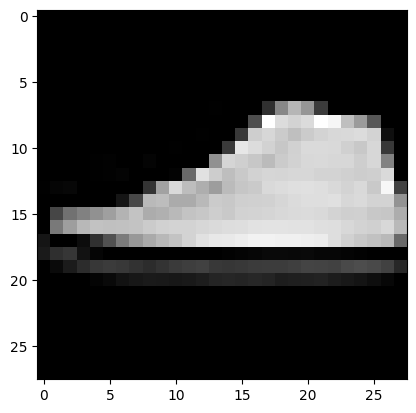

In [4]:
# Show an image from dataset

import cv2
import matplotlib.pyplot as plt

image_data = cv2.imread('fashion_mnist_images/train/7/0002.png', cv2.IMREAD_UNCHANGED)
plt.imshow(image_data, cmap='gray')
plt.show()

In [5]:
# Fill in X and y for training

import numpy as np


def load_mnist_dataset(path):
    labels = Path(FOLDER) / path

    X = []
    y = []
    for label in labels.iterdir():
        for file in label.iterdir():
            image = cv2.imread(str(file), cv2.IMREAD_UNCHANGED)
            X.append(image)
            y.append(label.name)
    
    return np.array(X), np.array(y).astype(np.uint8)


print('Loading up the training dataset...')
X, y = load_mnist_dataset('train')

print('Loading up the testing dataset...')
X_test, y_test = load_mnist_dataset('test')

print('Done!')

Loading up the training dataset...
Loading up the testing dataset...
Done!


In [6]:
# Scale the pixel values from (0 to 255) to (-1 to 1)

X = (X.astype(np.float32) - 127.5) / 127.5
X_test = (X_test.astype(np.float32) - 127.5) / 127.5

print(X.min(), X.max())
print(X.shape)

-1.0 1.0
(60000, 28, 28)


In [7]:
# Flatten images

X = X.reshape(X.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print(X.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [8]:
# Shuffle the X and y

keys = np.array(range(X.shape[0]))
np.random.shuffle(keys)

X = X[keys]
y = y[keys]

print(y[:10])

[8 8 8 8 9 4 0 3 8 1]


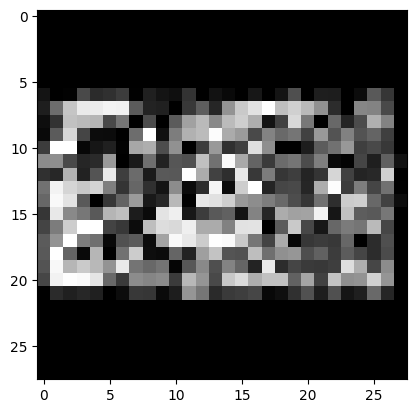

8


In [9]:
# Check whether the shuffling was applied correctly

plt.imshow(X[1337].reshape(28, 28), cmap='gray')
plt.show()

print(y[1337])

# (Check manually)

In [32]:
# Build the model and start training
# Managed to get this up to 89% validation accuracy and 0.33 loss

from src.model.model import Model

from src.layer.dense import Dense
from src.layer.dropout import Dropout
from src.activation.relu import ReLU
from src.activation.softmax import Softmax

from src.loss.categorical_crossentropy import CategoricalCrossentropy
from src.optimizers.adam import Adam
from src.accuracy.categorical import Categorical


model = Model(
    Dense(X.shape[1], 128),
    ReLU(),
    Dense(128, 128, l2_regularizer_w=5e-4, l2_regularizer_b=5e-4),
    Dropout(rate=0.1),
    ReLU(),
    Dense(128, 10),
    Softmax(),
    loss=CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=0.0025, decay=1e-3),
    accuracy=Categorical()
)

model.train(X, y, validation_data=(X_test, y_test), epochs=20, batch_size=128, print_every=100)

--- Epoch 1 ---
step: 0, acc: 0.148, loss: 2.909 (data_loss: 2.828, reg_loss: 0.081), lr: 0.0025
step: 100, acc: 0.820, loss: 0.511 (data_loss: 0.443, reg_loss: 0.068), lr: 0.002274795268425842
step: 200, acc: 0.859, loss: 0.448 (data_loss: 0.388, reg_loss: 0.060), lr: 0.002085070892410342
step: 300, acc: 0.867, loss: 0.441 (data_loss: 0.387, reg_loss: 0.054), lr: 0.001924557351809084
step: 400, acc: 0.844, loss: 0.424 (data_loss: 0.374, reg_loss: 0.050), lr: 0.0017869907076483202
step: 468, acc: 0.865, loss: 0.519 (data_loss: 0.471, reg_loss: 0.048), lr: 0.0017041581458759373
Epoch 1 finished - acc: 0.728, loss: 0.5643572362455673 (data_loss: 0.517, reg_loss: 0.048), lr: 0.0017029972752043599

--- Epoch 2 ---
step: 0, acc: 0.852, loss: 0.456 (data_loss: 0.409, reg_loss: 0.048), lr: 0.0017029972752043599
step: 100, acc: 0.852, loss: 0.426 (data_loss: 0.381, reg_loss: 0.045), lr: 0.0015943877551020409
step: 200, acc: 0.914, loss: 0.297 (data_loss: 0.255, reg_loss: 0.042), lr: 0.00149880

In [33]:
# Evaluate model on the training data, because why not?

model.evaluate(X, y, batch_size=128)

Evaluation - acc: 0.941, loss: 0.162


In [34]:
# Save the model

SAVE_PATH = 'mnist_fashion_model.pkl'

model.save(SAVE_PATH)

print(f'Saved the model to {SAVE_PATH}')

Saved the model to mnist_fashion_model.pkl


In [35]:
# Check whether Model.save() is working properly

model = Model.load(SAVE_PATH)

model.evaluate(X, y, batch_size=128)

Evaluation - acc: 0.941, loss: 0.162


In [36]:
# Check whether Model.predict() is working properly
# This should return [0, 0, 0, 0, 0]

confidences = model.predict(X_test[:5])
predictions = model.output_layer.get_predictions(confidences)

print(predictions)

[0 0 0 0 0]


In [37]:
# Humanize the predictions

fashion_mnist_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

print([fashion_mnist_labels[label] for label in predictions])

['T-shirt/top', 'T-shirt/top', 'T-shirt/top', 'T-shirt/top', 'T-shirt/top']


In [84]:
# Try out the model on out-of-dataset data

import requests


def get_image_from_url(url):
    # Load from url
    img_data = requests.get(url).content
    
    # Parse to NumPy array with grayscale
    img_data = cv2.imdecode(np.frombuffer(img_data, np.uint8), cv2.IMREAD_GRAYSCALE)
    
    # Resize
    img_data = cv2.resize(img_data, (28, 28))
    
    # Invert the image (the BG in training data is black)
    img_data = 255 - img_data
    
    return img_data

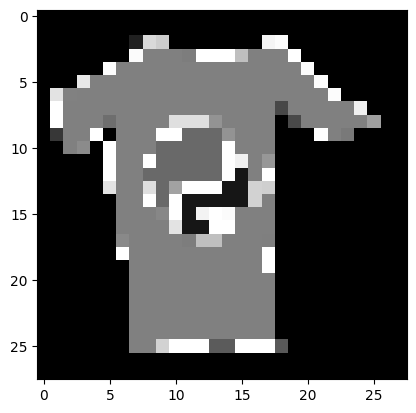

In [88]:
# Load up the T-shirt image

images = []

IMAGE_URL = 'https://nnfs.io/datasets/tshirt.png'

image = get_image_from_url(IMAGE_URL)
images.append(image)

plt.imshow(image, cmap='gray')
plt.show()

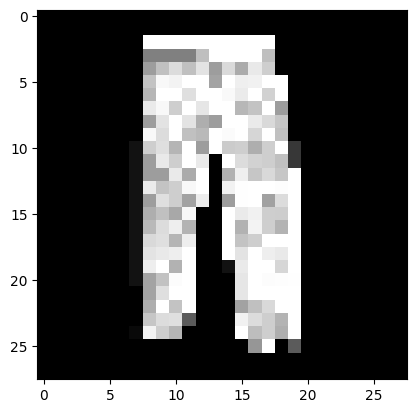

In [89]:
# Load up pants as well

IMAGE_URL = 'https://nnfs.io/datasets/pants.png'

image = get_image_from_url(IMAGE_URL)
images.append(image)

plt.imshow(image, cmap='gray')
plt.show()

In [90]:
# Reshape the data and scale to (-1, 1) range
# Then make a prediction, should tell that this is a T-shirt and Trouser

X = ((np.array(images).reshape(-1, 28 * 28).astype(np.float32)) - 127.5) / 127.5

confidences = model.predict(X)
predictions = model.output_layer.get_predictions(confidences)

print([fashion_mnist_labels[label] for label in predictions])

['T-shirt/top', 'Trouser']
